In [2]:
#Importing the libararies 
import pandas as pd
import numpy as np 


#loading the dataset
df_train = pd.read_csv(r'mnist_train.csv', encoding = 'UTF=8')
df_test = pd.read_csv(r'mnist_test.csv', encoding = 'UTF-8')

In [134]:
#data wrangling for the model 

np_data = np.array(df_train)
X_train = np_data[:,1:] # All except label col [0]
X_train = X_train/255 # Image normalize
y_train = np.reshape(np_data[:,0],(1,-1))

np_data = np.array(df_test)
X_test = np_data[:,1:] # All except label col [0]
X_test = X_test/255 #Image normalize
y_test = np.reshape(np_data[:,0],(1,-1))

In [135]:
print ('X_train: '+ str(X_train.shape) + ' and y_train: ' + str(y_train.shape) )
print ('X_test: '+ str(X_test.shape) + ' and y_test: ' + str(y_test.shape) )

X_train: (60000, 784) and y_train: (1, 60000)
X_test: (10000, 784) and y_test: (1, 10000)


In [136]:
#utility function that will need later
def one_hot_encoding(y):
  classes = np.reshape(np.unique(y),(-1,1))
  return np.equal(classes,y)*1
def one_hot_decoding(y):
    return np.argmax(y,axis=0).reshape((1,-1))

def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred, axis = 0) / len(y_true)

In [137]:
def confusion__matrix(y_true, y_pred):
  lbls = len(np.unique(y_true)) 
  cm = np.zeros((lbls, lbls))
  for i in range(len(y_pred)):
    cm[y_true[i]][y_pred[i]] += 1
  return cm

In [138]:
def classification__report(cm):
  true_pos = np.diag(cm)
  false_pos = np.sum(cm, axis=0) - true_pos
  false_neg = np.sum(cm, axis=1) - true_pos
  precision, recall, f1 = ([] for i in range (3))
  for i in range(len(true_pos)):
    pre = true_pos[i]/(true_pos[i] + false_pos[i])
    rec = true_pos[i]/(true_pos[i] + false_neg[i])
    precision.append(pre)
    recall.append(rec)
    f1.append(((pre + rec) / (pre + rec)))
  return (precision, recall, f1)

In [139]:
def __print (precision, recall, f1):
  c = f'{"Class":<10}'
  p = f'{"Precision":<20}'
  r = f'{"Recall":<20}'
  f = f'{"F1":<20}'
  print (c, p, r, f)
  for i in range (len(f1)):
    print (f'{str(i):<10}', f'{precision[i]:<20}', f'{recall[i]:<20}', f'{f1[i]:<15}')

In [140]:
print (y_train.shape)
y_train = one_hot_encoding(y_train.astype("int"))
y_test = one_hot_encoding(y_test.astype("int"))

(1, 60000)


In [141]:
# activations for the layers to be added 
def relu(x):
  return (np.maximum (0, x))

def relu_gradient(x):
  return (np.where (x > 0, 1, 0))

def sigmoid(x):
  #warnings.filterwarnings('ignore')
  return (1/(1+np.exp(-x)))

def sigmoid_gradient (x):
  #y = x
  
  #sigmoid (x)
  #warnings.filterwarnings('ignore')
  return (np.exp(-x))/((np.exp(-x)+1)**2)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims = True)
def softmax_gradient(x):
  y = softmax(x)
  return y * (1 - y)


In [142]:
class SparseCrossEntropy():
  def __init__(self):
    self.min_value = 1e-15
    self.max_value = 1 - self.min_value
  def loss(self, y, p):
    p = np.clip(p, self.min_value, self.max_value) #clipping the values in the range
    return -y*np.log(p) - (1 - y) * np.log(1- p)
  
  def loss_gradient(self, y, p):
    p = np.clip(p, self.min_value, self.max_value)
    return -(y/p) + (1 - y) / (1 - p)


In [143]:
class Activation():
  def __init__(self, activation, gradient, name="activation_layer"):
    self.activation = activation
    self.gradient = gradient
    self.input = None
    self.output = None
    self.name = name
  
  def forward(self, x):
    self.input = x
    self.output = self.activation(x)
    return self.output
  
  def backward(self, output_error, lr = 0.01):
    return self.gradient(self.input) * output_error
  
  def __call__(self, x):
    return self.forward(x)


In [144]:
class Linear():
  def __init__(self, input, output, name="linear_layer"):
    limit = 1 / np.sqrt(input)
    self.W = np.random.uniform(-limit, limit, (input, output)) # initial weights
    self.b = np.zeros((1, output)) # Biases
    self.input = None
    self.output = None
    self.name = name
  
  def forward(self, x):
    self.input = x
    self.output = np.dot(self.input, self.W) + self.b # Wx + b
    return self.output
  
  def backward(self, output_error, lr = 0.01):
    input_error = np.dot(output_error, self.W.T)
    delta = np.dot(self.input.T, output_error) # Calculate the weights error

    #stochastic gradient descent optimization

    self.W -= lr * delta
    self.b -= lr * np.mean(output_error)
    return input_error
  
  def __call__(self, x):
    return self.forward(x)


In [145]:
class Dropout: 

  def __init__(self, p, name="dropout_layer"):
    self.input = None
    self.prob = p
    self.name = name

  def forward(self, x, p):
    self.input = x
    self.prob = p
    binary_value = np.random.rand(self.input.shape[0], self.input.shape[1]) < self.prob
    res = np.multiply(self.input, binary_value)
    res /= self.prob  # this line is called inverted dropout technique
    return res
  def __call__(self, x):
    return self.forward(x, self.prob)


In [146]:
class Network():
  
  def __init__(self, activationName, input_dim, output_dim, lr=0.01):
    if (activationName=="relu"):
        self.layers = [
                       Linear(input_dim, 256, name="input"),
                       Activation(relu, relu_gradient, name="relu1"),
                       Linear(256, 128, name="input"),
                       Activation(relu, relu_gradient, name="relu2"),
                       Dropout(p=0.8,name="dropout"),
                       Linear(128, output_dim, name="output"),
                       Activation(softmax, softmax_gradient, name="softmax")
                       ]
    if (activationName=="sigmoid"):
        self.layers = [
                       Linear(input_dim, 256, name="input"),
                       Activation(sigmoid, sigmoid_gradient, name="sigmoid1"),
                       Linear(256, 128, name="input"),
                       Activation(sigmoid, sigmoid_gradient, name="sigmoid2"),
                       Dropout(p=0.8,name="dropout"),
                       Linear(128, output_dim, name="output"),
                       Activation(softmax, softmax_gradient, name="softmax")
                       ]
    self.lr = lr
  
  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def backward(self, loss_grad):
    for layer in reversed(self.layers):
      if layer.name != 'dropout':
        loss_grad = layer.backward(loss_grad, self.lr)
  def summary (self):
    for layer in self.layers:
      if layer.name != "dropout":
        print (type(layer).__name__ ,"---", layer.name, "---", layer.input.shape, "---", layer.output.shape)
      else: 
        print (type(layer).__name__, "------", layer.input.shape, "---", "Prob:", layer.prob)
  def __call__(self, x):
    return self.forward(x)


In [147]:
def batch_loader(X, y = None, size=64):
  n_samples = X.shape[0]
  for i in np.arange(0, n_samples, size):
    start, end = i, min(i + size, n_samples)
    if y is not None:
      yield X[start:end], y[start: end]
    else:
      yield X[start:end]


In [148]:
criterion = SparseCrossEntropy()
activationName = str(input("Enter which activation function you would to use between sigmoid and relu: "))
while not(activationName == "sigmoid" or activationName=="relu"):
    activationName = str(input("Enter which activation function you would to use between sigmoid and relu: "))
#activationName.lower()
n_input_dim = 28*28 
n_out = 10 
y_train = y_train.T
y_test = y_test.T

model = Network(activationName, n_input_dim, n_out, lr=0.001)


Enter which activation function you would to use between sigmoid and relu: relu


In [150]:
e = int(input("Enter a reasonable number of epochs: "))

v_loss, v_acc, t_loss, t_acc = ([] for i in range (4))
epochs = e
for epoch in range(epochs):
  loss = []
  acc = []
  for x_batch, y_batch in batch_loader(X_train, y_train):
    out = model(x_batch) # Forward pass
    loss.append(np.mean(criterion.loss(y_batch, out)))
    # We just passed the inputs incorrectly.
    acc.append(accuracy(np.argmax(y_batch, axis=1), np.argmax(out, axis=1)))

    error = criterion.loss_gradient(y_batch, out) # Calculating the gradient of loss
    model.backward(error) # Backpropagation
  
  t_acc.append(np.mean(acc))
  t_loss.append(np.mean(loss))
  print(f"Epoch {epoch + 1}, Loss: {np.mean(loss)}, Acc: {np.mean(acc)}")

  #validation of model performance

  out = model(X_test)
  v_loss.append(np.mean(criterion.loss(y_test, out)))
  v_acc.append(accuracy(np.argmax(y_test, axis=1), np.argmax(out, axis=1)))


Enter a reasonable number of epochs: 5
Epoch 1, Loss: 0.02299975220056574, Acc: 0.9612040245202559
Epoch 2, Loss: 0.02070976532986676, Acc: 0.9657849147121536
Epoch 3, Loss: 0.01865604697245637, Acc: 0.9686667110874201
Epoch 4, Loss: 0.01724249378892186, Acc: 0.9711653784648188
Epoch 5, Loss: 0.01583690201053535, Acc: 0.9736640458422174


In [151]:
model.summary()

Linear --- input --- (10000, 784) --- (10000, 256)
Activation --- relu1 --- (10000, 256) --- (10000, 256)
Linear --- input --- (10000, 256) --- (10000, 128)
Activation --- relu2 --- (10000, 128) --- (10000, 128)
Dropout ------ (10000, 128) --- Prob: 0.8
Linear --- output --- (10000, 128) --- (10000, 10)
Activation --- softmax --- (10000, 10) --- (10000, 10)


In [152]:
out = model(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(out, axis=1)

print (accuracy(y_true, y_pred) * 100)
cm = confusion__matrix(y_true, y_pred)
cm = cm.astype(int)
print (cm)

96.73
[[ 964    0    1    2    1    9    1    1    0    1]
 [   0 1127    1    3    0    0    1    0    3    0]
 [   7    8  993    6    5    1    1    7    3    1]
 [   0    3    4  977    1    7    0    8    3    7]
 [   1    0    5    0  953    1    3    2    1   16]
 [   3    1    0    4    1  874    3    0    4    2]
 [   7    4    1    1   11   22  907    1    4    0]
 [   0   14    9    1    3    1    0  988    1   11]
 [   6    3    2    8    4    6    2    8  927    8]
 [   2    5    0    7   14   10    0    7    1  963]]


In [153]:
precision, recall, f1 = classification__report(cm)
__print(precision, recall, f1)


Class      Precision            Recall               F1                  
0          0.9737373737373738   0.9836734693877551   1.0            
1          0.967381974248927    0.9929515418502203   1.0            
2          0.9773622047244095   0.9622093023255814   1.0            
3          0.9682854311199207   0.9673267326732673   1.0            
4          0.959718026183283    0.9704684317718941   1.0            
5          0.9387755102040817   0.9798206278026906   1.0            
6          0.9880174291938998   0.9467640918580376   1.0            
7          0.9667318982387475   0.9610894941634242   1.0            
8          0.9788806758183738   0.9517453798767967   1.0            
9          0.9544103072348861   0.9544103072348861   1.0            


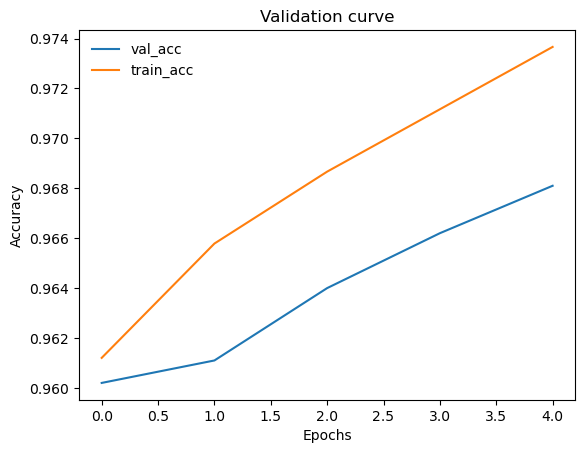

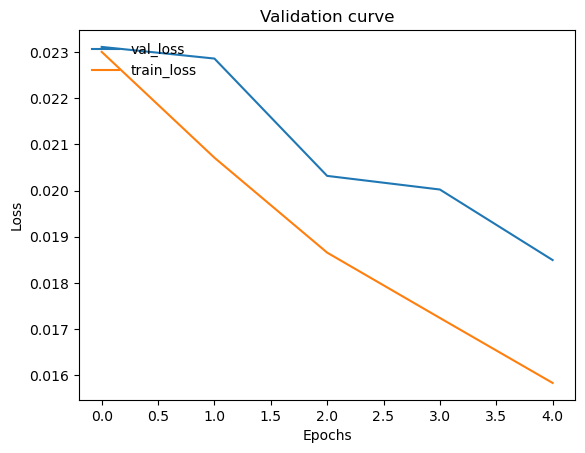

In [154]:
import matplotlib.pyplot as plt

epc = np.arange(epochs)
#validation curve for accuracy
plt.plot(epc, v_acc, label = 'val_acc')
plt.plot(epc, t_acc, label = 'train_acc')
plt.title('Validation curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left', frameon=False)
plt.show()

#validation curve for loss 

plt.plot(epc, v_loss, label = 'val_loss')
plt.plot(epc, t_loss, label = 'train_loss')
plt.title('Validation curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left', frameon=False)
plt.show()
